In [1]:
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.gmm import GMM
from pyod.models.xgbod import XGBOD
from pyod.models.pca import PCA
from pyod.models.kde import KDE

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from torch.nn import MSELoss

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from pipeline import load_network


In [2]:
load = input('Load previous loaded network? (y/n): ')
if load.lower()[0] == 'n':
    path = input('Enter file name to save as: ') + '.sav'
    
    result = load_network(input('Enter dataset/network path: '))

    saved_model = open(path, 'wb')
    pickle.dump(result, saved_model)
    saved_model.close()
else:
    with open(input('Enter file path: '), 'rb') as f:
        G, ego_gs, roots, labels = pickle.load(f)
        f.close()
        roots = [int(r) for r in roots]

In [10]:
with open(input('Enter file path for errors: '), 'rb') as f:
    reconstruction_errors = pickle.load(f)

In [13]:
with open(input('Enter file path for random errors: '), 'rb') as f:
    random_errors = pickle.load(f)

In [11]:
anom_errors = [error[0] for i, error in enumerate(reconstruction_errors) if labels[i] == 1.0]
clean_errors = [error[0] for i, error in enumerate(reconstruction_errors) if labels[i] == 0.0]

In [12]:
print(len([error for error in anom_errors if error > 0.98]), len(anom_errors))
print(len([error for error in clean_errors if error > 0.98]), len(clean_errors))

221 298
3753 4898


Text(0.5, 1.0, 'Tucker Decomposition - Reconstruction Errors')

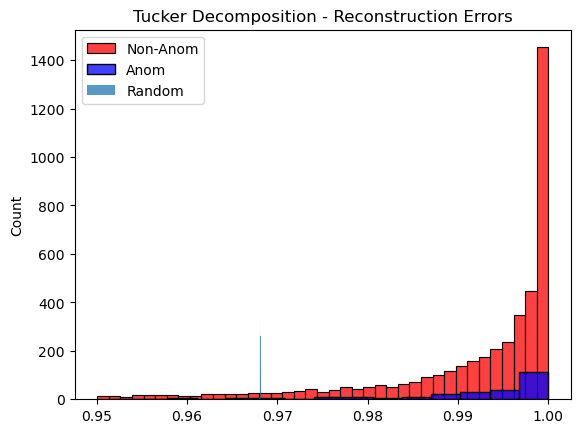

In [33]:
sns.histplot([error for error in clean_errors if error > 0.95], color='r', ax=plt.gca())
sns.histplot([error for error in anom_errors if error > 0.95], color='b')
sns.histplot(random_errors, color='g')

# sns.histplot(clean_errors, color='r', ax=plt.gca())
# sns.histplot(anom_errors, color='b')

plt.legend(['Non-Anom', 'Anom', 'Random'])

decomp = int(input('Tucker(1) or Parafac(2)?: '))
if decomp == 1:
    decomp = 'Tucker Decomposition'
elif decomp == 2:
    decomp = 'Parafac Decomposition'

plt.title(f'{decomp} - Reconstruction Errors')

Text(0.5, 1.0, 'Random Graph Reconstruction Errors')

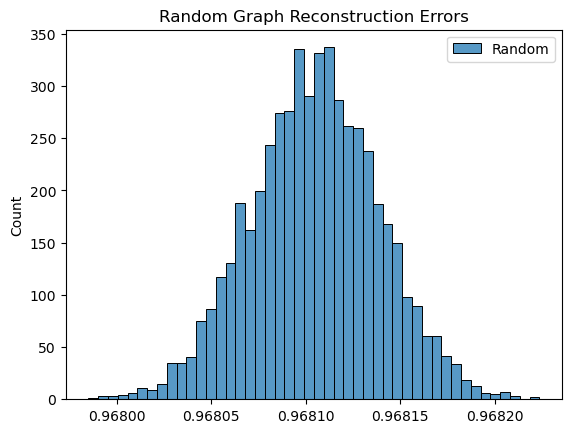

In [32]:
sns.histplot(random_errors, color='g')
plt.legend(['Random'])

plt.title('Random Graph Reconstruction Errors')

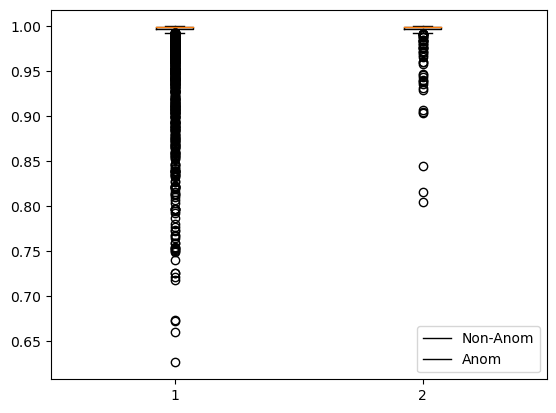

In [14]:
plt.boxplot([clean_errors, anom_errors])

plt.legend(['Non-Anom', 'Anom'])

In [23]:
reconstruction_errors = np.column_stack((reconstruction_errors, np.zeros(len(reconstruction_errors))))

In [5]:
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(reconstruction_errors)

Text(0.5, 1.0, 'Precision Recall Curve')

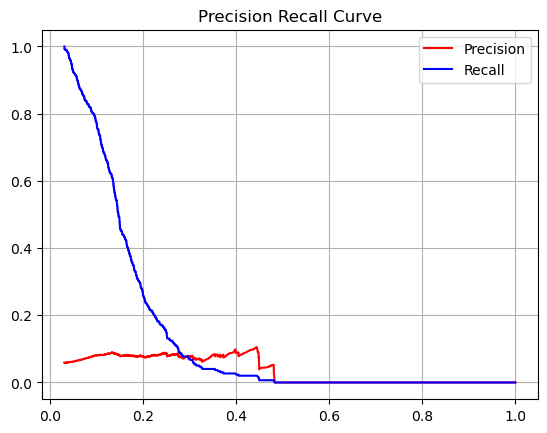

In [6]:
precision, recall, threshold = precision_recall_curve(labels, embeddings[:, 0])

plt.plot(threshold, precision[:-1], c='r', label='Precision')
plt.plot(threshold, recall[:-1], c='b', label='Recall')
plt.grid()

plt.legend()
plt.title('Precision Recall Curve')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.33, random_state=42)

In [8]:
lof = LOF()

model_name = type(lof).__name__

lof.fit(X_train, y_train)

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/pyod/models/base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [9]:
y_train_pred = lof.labels_
y_train_scores = lof.decision_scores_

y_test_pred = lof.predict(X_test) 
y_test_scores = lof.decision_function(X_test) 
y_test_proba = lof.predict_proba(X_test)

In [10]:
evaluate_print(model_name, y_test, y_test_scores)

LOF ROC:0.4774, precision @ rank n:0.0408


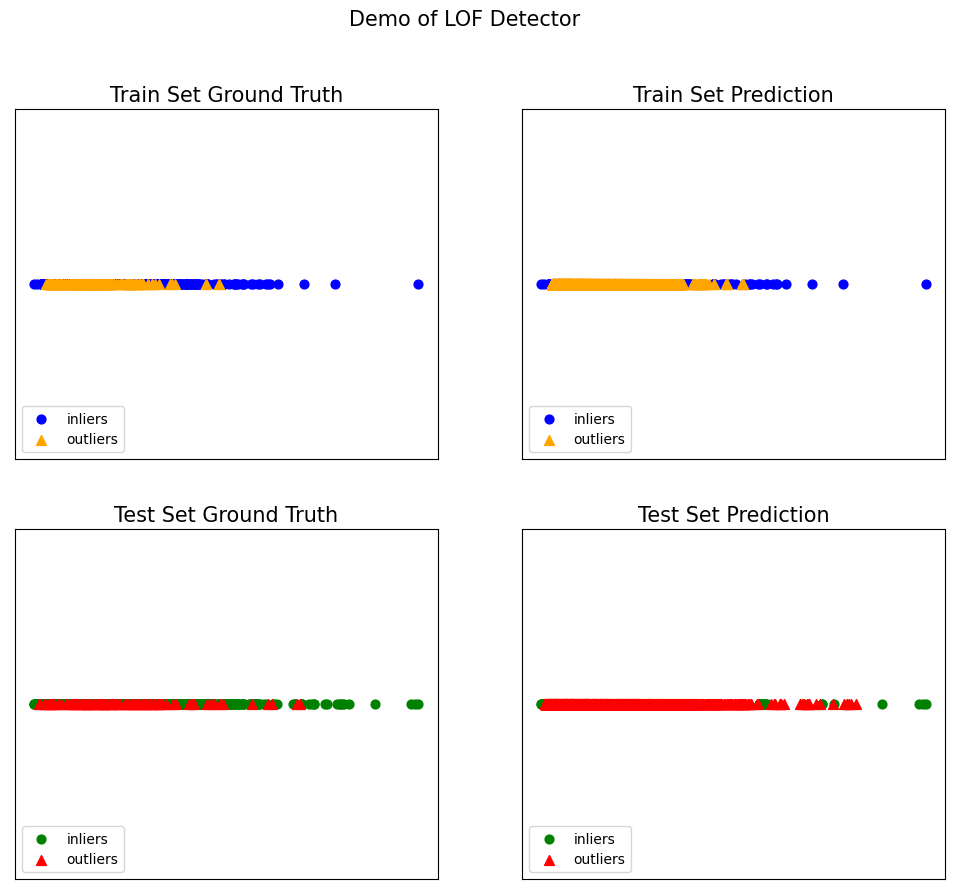

In [11]:
visualize(type(lof).__name__, X_train, y_train, X_test, y_test, [1 if y == 0 else 0 for y in y_train_pred],
          [1 if y == 0 else 0 for y in y_test_pred], show_figure=True, save_figure=False)

In [12]:
precision, recall, threshold = precision_recall_curve(y_test, y_test_proba[:, 1])

Text(0.5, 1.0, 'Precision Recall Curve: LOF')

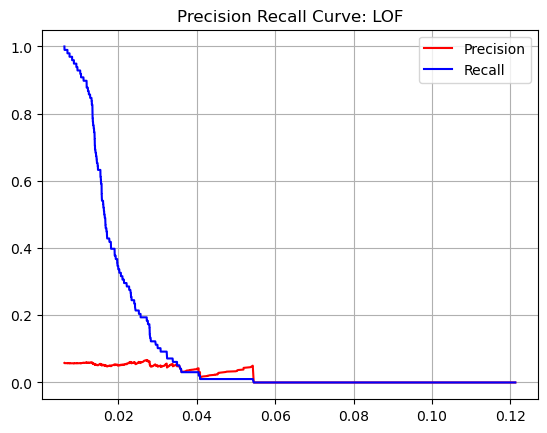

In [13]:
plt.plot(threshold, precision[:-1], c='r', label='Precision')
plt.plot(threshold, recall[:-1], c='b', label='Recall')
plt.grid()

plt.legend()
plt.title(f'Precision Recall Curve: {model_name}')

In [14]:
print(f'{model_name} Classification Report:\n')
print(classification_report(y_test, y_test_pred))

LOF Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1617
           1       0.05      0.10      0.07        98

    accuracy                           0.84      1715
   macro avg       0.50      0.49      0.49      1715
weighted avg       0.89      0.84      0.86      1715



In [15]:
ifor = IForest(behaviour='new')

model_name = type(ifor).__name__

ifor.fit(X_train, y_train)

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/pyod/models/base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [16]:
ifor.fit(X_train, y_train)
y_train_pred = ifor.labels_
y_train_scores = ifor.decision_scores_

y_test_pred = ifor.predict(X_test) 
y_test_scores = ifor.decision_function(X_test) 
y_test_proba = ifor.predict_proba(X_test)

evaluate_print(model_name, y_test, y_test_scores)

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/pyod/models/base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


IForest ROC:0.5493, precision @ rank n:0.0816


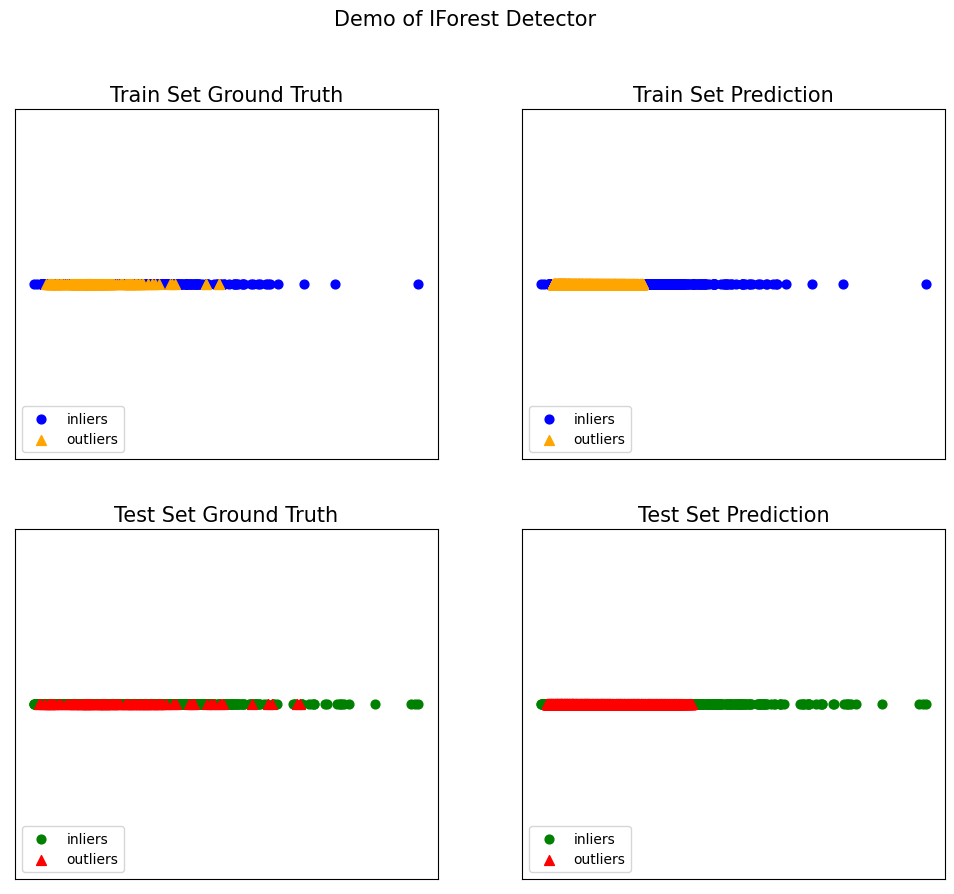

In [17]:
visualize(type(ifor).__name__, X_train, y_train, X_test, y_test, [1 if y == 0 else 0 for y in y_train_pred],
          [1 if y == 0 else 0 for y in y_test_pred], show_figure=True, save_figure=False)

Text(0.5, 1.0, 'Precision Recall Curve: IForest')

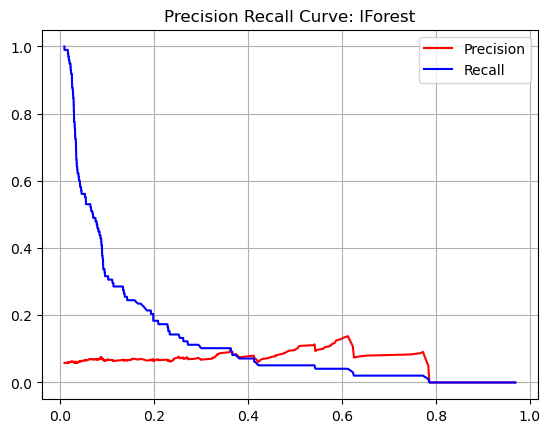

In [18]:
precision, recall, threshold = precision_recall_curve(y_test, y_test_proba[:, 1])
plt.plot(threshold, precision[:-1], c='r', label='Precision')
plt.plot(threshold, recall[:-1], c='b', label='Recall')
plt.grid()

plt.legend()
plt.title(f'Precision Recall Curve: {model_name}')

In [19]:
print(f'{model_name} Classification Report:\n')
print(classification_report(y_test, y_test_pred))

IForest Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1617
           1       0.07      0.14      0.09        98

    accuracy                           0.84      1715
   macro avg       0.51      0.51      0.50      1715
weighted avg       0.89      0.84      0.87      1715



In [20]:
def convert_probs_to_preds(probs, threshold=0.5):
    return [1.0 if prob >= threshold else 0.0 for prob in probs]

In [46]:
lof_results = lof.predict_proba(X_test)[:, 1]
ifor_results = ifor.predict_proba(X_test)[:, 1]

In [96]:
thresholds = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
# thresholds = [0.01, 0.035, 0.05, 0.075, 0.1]

old_pred = [0.0] * len(X_test)

for threshold in thresholds:
    preds = [0.0] * len(X_test)
    for i in range(len(X_test)):
        if lof_results[i] >= threshold and ifor_results[i] >= threshold:
            preds[i] = 1.0

    # print(old_pred == preds)
    # print(np.unique(old_pred, return_counts=True))
    # print(np.unique(preds, return_counts=True))
    old_pred = preds

    print(f'Intersection Classification Report @ Threshold {threshold}:\n')
    print(classification_report(y_test, preds), '\n')
    # print(confusion_matrix(y_test, preds))

Intersection Classification Report @ Threshold 0.01:

              precision    recall  f1-score   support

           0       0.96      0.09      0.17      1617
           1       0.06      0.93      0.11        98

    accuracy                           0.14      1715
   macro avg       0.51      0.51      0.14      1715
weighted avg       0.90      0.14      0.17      1715
 

Intersection Classification Report @ Threshold 0.05:

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1617
           1       0.06      0.01      0.02        98

    accuracy                           0.93      1715
   macro avg       0.50      0.50      0.49      1715
weighted avg       0.89      0.93      0.91      1715
 

Intersection Classification Report @ Threshold 0.1:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1617
           1       0.00      0.00      0.00        98

    accuracy     

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [100]:
kde = KDE()

model_name = type(kde).__name__

kde.fit(X_train, y_train)

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/pyod/models/base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


KDE(algorithm='auto', bandwidth=1.0, contamination=0.1, leaf_size=30,
  metric='minkowski', metric_params=None)

In [101]:
y_train_pred = kde.labels_
y_train_scores = kde.decision_scores_

y_test_pred = kde.predict(X_test) 
y_test_scores = kde.decision_function(X_test) 
y_test_proba = kde.predict_proba(X_test)

In [102]:
evaluate_print(model_name, y_test, y_test_scores)

KDE ROC:0.4744, precision @ rank n:0.0918
